<a href="https://colab.research.google.com/github/habibsifat/Algorithm-for-Bengali-Error-Dataset-Generation/blob/master/ISMB_covid_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ete3

In [3]:
from ete3 import Tree
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

In [67]:
vertices = []
vertices_no = 0
graph = []
edge_frequencies = defaultdict(int)
all_internal_nodes = []


def identify_nodes(tree):
    leaf_nodes = []
    for node in tree.traverse("postorder"):
        if node.is_leaf():
            leaf_nodes.append(node.name)
    return leaf_nodes


def add_vertex(v):
    global graph
    global vertices_no
    global vertices
    if v not in vertices:
      vertices_no = vertices_no + 1
      vertices.append(v)
      if vertices_no > 1:
          for vertex in graph:
              vertex.append(0)
      temp = []
      for i in range(vertices_no):
          temp.append(0)
      graph.append(temp)

def add_edge(v1, v2, e):
    global graph
    global vertices_no
    global vertices
    edge_frequencies[(v1, v2)] += 1
    edge_frequencies[(v2, v1)] += 1  # Assuming an undirected graph
    index1 = vertices.index(v1)
    index2 = vertices.index(v2)
    # Check if an edge already exists between v1 and v2
    if graph[index1][index2] != 0:
        existing_weight = graph[index1][index2]
        new_weight = (existing_weight + e) / 2
        new_weight = round(new_weight, 2)
        graph[index1][index2] = new_weight
    else:
        graph[index1][index2] = e


def update_internal_node_names(tree, leaf_nodes):
    internal_nodes = []
    def update_internal_node(node):
        if not node.is_leaf():
            children_names = sorted([child.name for child in node.children])
            new_name = ''.join(children_names)
            new_name = ''.join(sorted(new_name))
            if new_name in leaf_nodes:
                new_name = generate_unique_name(new_name)
            node.name = new_name
            internal_nodes.append(node.name)
            if node.name not in all_internal_nodes:
              all_internal_nodes.append(node.name)

    def generate_unique_name(name):
        # Generate a unique name by adding a suffix
        suffix = 1
        while name + str(suffix) in leaf_nodes:
            suffix += 1
        return name + str(suffix)

    for node in tree.traverse("postorder"):
        update_internal_node(node)
    return internal_nodes


def calculate_distance_matrices(tree):
    # Get a list of all unique nodes (leaves and internal nodes)
    unique_nodes = set(tree.iter_leaves())
    unique_nodes.update(tree.traverse("preorder"))

    # Create a matrix to represent the distances
    node_names = [node.name for node in unique_nodes]  # Define node_names here
    node_names.sort(key=lambda x: (tree & x).get_distance(tree))
    # Initialize a dictionary to store distances between nodes
    distance_matrix = []
    distances = {}
    for node in node_names:
        add_vertex(node)
    # Calculate distances
    for node1 in unique_nodes:
        for node2 in unique_nodes:
            if node1 != node2:
                distance = node1.get_distance(node2)
                distances[(node1.name, node2.name)] = distance
    # add edge
    for node1 in node_names:
        for node2 in node_names:
            if node1 != node2:
                distance1 = distances.get((node1, node2), 0)
                distance1 = round(distance1, 2)
                add_edge(node1, node2, distance1)

    for node1 in node_names:
        row = [distances.get((node1, node2), 0) for node2 in node_names]
        distance_matrix.append(row)
    distance_matrix = [[round(value, 2) for value in row] for row in distance_matrix]

    condensed_distance_matrix = []
    for i in range(len(node_names)):
        row = [distances.get((node_names[i], node_names[j]), 0) for j in range(i + 1)]
        condensed_distance_matrix.append(row)

    condensed_distance_matrix = [[round(value, 2) for value in row] for row in condensed_distance_matrix]
    return distance_matrix


input_file = '/content/12trees23.txt'
with open(input_file, 'r') as file:
    for idx, line in enumerate(file, 1):
        tree = Tree(line.strip(), format=1)
        leaf_nodes = identify_nodes(tree)
        # print(leaf_nodes)
        internal_nodes = update_internal_node_names(tree,leaf_nodes)
        # print(internal_nodes)
        distance_matrix2 = calculate_distance_matrices(tree)

# print('\nnumber of internal nodes:',len(internal_nodes))
print('\nnumber of all internal nodes:',len(all_internal_nodes))
print('\nall internal nodes:',all_internal_nodes)
print('\nall vertices:',vertices)
print('\nnumber of vertices:',vertices_no)




number of all internal nodes: 60

all internal nodes: ['231', '5678', '019', '01456789', '01123456789', '111123', '1156', '1189', '111111111123456789', '01111111111112233445566778899', '00111111111111112222222333445566778899', '111456', '1112', '111111123456', '1122223', '011222223', '567', '00111122222233456789', '00111111111112222222333445566789', '0011111111111122222223334455667789', '11111234', '11111111234789', '45678', '12345678', '0112222', '01112222223345678', '111567', '11111111234567', '0222', '01222223', '78', '56', '01111111111111222222233344556677889', '111789', '123', '0011111111111122222223334456778899', '013456789', '0123456789', '0011122222233456789', '00111112222223345566789', '0011111111112222222333445566789', '0011111111111112222222333445566778899', '568', '0149', '011111111111122222233456789', '011111111111112222222333456789', '1111112389', '11114789', '1111112356', '001111111111111122222223334567899', '0011111111111111222222233344567899', '0122223', '11222', '678

In [ ]:
# Extract unique node names
nodes = sorted(set(node for edge in edge_frequencies for node in edge))

# Create an empty 2D array filled with zeros
num_nodes = len(nodes)
print('\nnodes:',nodes)
print('\nnumber of nodes:',num_nodes)
print('\nnumber of vertices:',vertices_no)
# Populate the frequency matrix with the values from the dictionary
frequency_matrix = [[0] * num_nodes for _ in range(num_nodes)]
for i in range(num_nodes):
    for j in range(num_nodes):
        node_i, node_j = nodes[i], nodes[j]
        if (node_i, node_j) in edge_frequencies:
            frequency_matrix[i][j] = edge_frequencies[(node_i, node_j)]
        elif (node_j, node_i) in edge_frequencies:
            frequency_matrix[i][j] = edge_frequencies[(node_j, node_i)]  # Assuming an undirected graph

dist_matrix = [[0 for _ in range(vertices_no)] for _ in range(vertices_no)]
for i in range(vertices_no):
  for j in range(vertices_no):
    if graph[i][j] != 0:
      dist_matrix[i][j] = graph[i][j]



# Define a function to remove cycles from the graph
def remove_cycles(graph):
    G = nx.Graph()

    # Add edges to a NetworkX graph
    for i in range(len(graph)):
        for j in range(i + 1, len(graph[i])):
            weight = graph[i][j]
            if weight != 0:
                G.add_edge(i, j, weight=weight)

    # Find cycles
    cycles = list(nx.cycle_basis(G))
    print('\ncycles are :',cycles)
    # Remove edges in cycles
    for cycle in cycles:
        for i in range(len(cycle)):
            j = (i + 1) % len(cycle)
            u, v = cycle[i], cycle[j]
            if graph[u][v] != 0:
                graph[u][v] = 0



# Define a function to remove duplicate edges
def remove_duplicates(graph):
    for i in range(len(graph)):
        for j in range(i + 1, len(graph[i])):
            if graph[i][j] == 0:
                continue
            if graph[i][j] != graph[j][i] and graph[j][i] != 0:
              print('duplicates are : ',graph[i][j], graph[j][i])
              # Keep the edge with average weight
              first_weight = graph[i][j]
              second_weight = graph[j][i]
              updated_weight = first_weight/second_weight
              updated_weight = round(updated_weight, 2)
              graph[i][j] = updated_weight
              graph[j][i] = 0


def modified_prims(graph, frequencies, internal_nodes):
    num_nodes = len(graph)
    mst = []
    in_mst = [False] * num_nodes

    # Create a mapping from node names to indices
    node_name_to_index = {name: index for index, name in enumerate(vertices)}

    # Debugging: Print the mappings and input lists
    print("Vertices:", vertices)
    print("Internal Nodes:", internal_nodes)
    print("Node Name to Index Mapping:", node_name_to_index)

    # Start from the first node of interest.
    start_node = internal_nodes[0]

    # Handle case where start_node might not be in the mapping
    if start_node not in node_name_to_index:
        print(f"Start node '{start_node}' not found in node_name_to_index mapping.")
        return []  # or handle this case as needed

    # Convert start_node from a name to an index
    start_node_index = node_name_to_index[start_node]

    # Use this index in your MST algorithm
    in_mst[start_node_index] = True

    while len(mst) < len(internal_nodes) - 1:
        max_frequency = -1
        chosen_edge = (None, None, float('inf'))  # Initialize with placeholder values

        for node_name in internal_nodes:
            node_index = node_name_to_index[node_name]
            if in_mst[node_index]:
                for neighbor_index, edge_weight in enumerate(graph[node_index]):
                    neighbor_name = vertices[neighbor_index]  # Get the name of the neighbor
                    if neighbor_name in internal_nodes and not in_mst[neighbor_index]:
                        frequency = frequencies[node_index][neighbor_index]
                        # if frequency >= max_frequency and edge_weight < chosen_edge[2]:
                        if frequency >= max_frequency:
                            max_frequency = frequency
                            # Store indices instead of names
                            chosen_edge = (node_index, neighbor_index, edge_weight)

        # After the loop, update in_mst and mst using indices
        # print("Chosen edge:", chosen_edge)
        # print("Type of chosen_edge[1]:", type(chosen_edge[1]))
        if chosen_edge[0] is not None and chosen_edge[1] is not None:
            # Use index for in_mst
            in_mst[chosen_edge[1]] = True
            # Convert indices back to names for mst
            mst.append((vertices[chosen_edge[0]], vertices[chosen_edge[1]]))


    return mst


def draw_mst(mst_G):
    # Draw the graph
    pos = nx.spring_layout(mst_G)  # Layout algorithm (you can choose another one)

    # Increase the figure size (adjust the width and height as needed)
    plt.figure(figsize=(15, 15))

    # Customize node and edge visual properties for clarity
    nx.draw(mst_G, pos, with_labels=True, node_size=30, node_color='skyblue', font_size=8, font_color='black', edge_color='gray', width=0.8)

    # Display the graph
    plt.axis('off')
    plt.show()

# Call the function to remove cycles from the graph
remove_cycles(graph)

# Call the function to remove duplicate edges
remove_duplicates(graph)

# Call the modified_prims function with the specified nodes
mst_result = modified_prims(dist_matrix, frequency_matrix, all_internal_nodes)
print('\nMST :',mst_result)
mst_G = nx.Graph()
for edge in mst_result:
    mst_G.add_edge(edge[0], edge[1])

draw_mst(mst_G)


**add leaf nodes**

In [69]:
import networkx as nx

# Assuming result is already obtained from modified_prims function
G = nx.Graph()
for edge in mst_result:
    G.add_edge(edge[0], edge[1])
# Create a mapping from node names to indices
node_name_to_index = {name: index for index, name in enumerate(vertices)}
# Assuming dist_matrix is a 2D array-like structure with distances between nodes
# and node_name_to_index is a dictionary mapping node names to their indices in dist_matrix
for leaf in leaf_nodes:
    leaf_index = node_name_to_index[leaf]
    nearest_internal_node = None
    min_distance = float('inf')
    max_freq = -1
    for internal_node in all_internal_nodes:
        internal_node_index = node_name_to_index[internal_node]
        distance = dist_matrix[leaf_index][internal_node_index]
        freq = frequency_matrix[leaf_index][internal_node_index]
        # if distance < min_distance:
        if distance < min_distance and freq >= max_freq:
            min_distance = distance
            nearest_internal_node = internal_node

    if nearest_internal_node is not None:
        G.add_edge(leaf, nearest_internal_node)

# Now G contains the original MST with leaf nodes connected to the nearest internal nodes


In [ ]:
# Draw the graph
pos = nx.spring_layout(G)  # Layout algorithm (you can choose another one)

# Increase the figure size (adjust the width and height as needed)
plt.figure(figsize=(15, 15))

# Customize node and edge visual properties for clarity
nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=8, font_color='black', edge_color='gray', width=1.0)

# Display the graph
plt.axis('off')
plt.show()

**remove extra internal nodes**

In [53]:
# import networkx as nx

# Assuming G is your graph with the MST and leaf nodes added
# all_internal_nodes is a list of all internal node names
# leaf_nodes is a list of all leaf node names

# Create a set of leaf nodes for faster lookup
# leaf_node_set = set(leaf_nodes)

# # Iterate over a copy of the internal nodes list to avoid modification during iteration
# for internal_node in all_internal_nodes[:]:
#     # Check the neighbors of the internal node
#     neighbors = list(G.neighbors(internal_node))

#     # Check if the internal node is connected only to one other internal node and no leaf nodes
#     if len(neighbors) == 1 and neighbors[0] in all_internal_nodes and not any(neighbor in leaf_node_set for neighbor in neighbors):
#         G.remove_node(internal_node)
#         all_internal_nodes.remove(internal_node)  # Optional: update the internal nodes list

# Now G contains only the internal nodes that are connected to leaf nodes or more than one internal node


In [64]:
# import networkx as nx

# # Assuming G is your graph with the MST and leaf nodes added
# # all_internal_nodes is a list of all internal node names
# # leaf_nodes is a list of all leaf node names

# # Create a set of leaf nodes for faster lookup
# leaf_node_set = set(leaf_nodes)

# # Iterate over a copy of the internal nodes list to avoid modification during iteration
# for internal_node in all_internal_nodes[:]:
#     # Check the neighbors of the internal node
#     neighbors = list(G.neighbors(internal_node))

#     # Check if the internal node is connected only to one other internal node and no leaf nodes
#     if len(neighbors) == 1 and neighbors[0] in all_internal_nodes and not any(neighbor in leaf_node_set for neighbor in neighbors):
#         G.remove_node(internal_node)
#         all_internal_nodes.remove(internal_node)
#     # New condition: if the internal node is connected to exactly one leaf node and one internal node
#     elif len(neighbors) == 2 and any(neighbor in leaf_node_set for neighbor in neighbors) and any(neighbor in all_internal_nodes for neighbor in neighbors):
#         # Identify the leaf node and the other internal node
#         leaf_node = next(neighbor for neighbor in neighbors if neighbor in leaf_node_set)
#         other_internal_node = next(neighbor for neighbor in neighbors if neighbor in all_internal_nodes)

#         # Remove the internal node and add an edge between the leaf node and the other internal node
#         G.remove_node(internal_node)
#         G.add_edge(leaf_node, other_internal_node)
#         all_internal_nodes.remove(internal_node)  # Optional: update the internal nodes list

# # Now G contains only the internal nodes that are connected to leaf nodes or more than one internal node


merge branch length

In [74]:
import networkx as nx

# Assuming G is your graph with the MST, leaf nodes added
# all_internal_nodes is a list of all internal node names
# leaf_nodes is a list of all leaf node names
# dist_matrix is the distance matrix storing branch lengths

# Create a set of leaf nodes for faster lookup
leaf_node_set = set(leaf_nodes)

# Iterate over a copy of the internal nodes list to avoid modification during iteration
for internal_node in all_internal_nodes[:]:
    # Check the neighbors of the internal node
    neighbors = list(G.neighbors(internal_node))

    # Check if the internal node is connected only to one other internal node and no leaf nodes
    if len(neighbors) == 1 and neighbors[0] in all_internal_nodes and not any(neighbor in leaf_node_set for neighbor in neighbors):
        G.remove_node(internal_node)
        all_internal_nodes.remove(internal_node)
    # New condition: if the internal node is connected to exactly one leaf node and one internal node
    elif len(neighbors) == 2 and any(neighbor in leaf_node_set for neighbor in neighbors) and any(neighbor in all_internal_nodes for neighbor in neighbors):
        # Identify the leaf node and the other internal node
        leaf_node = next(neighbor for neighbor in neighbors if neighbor in leaf_node_set)
        other_internal_node = next(neighbor for neighbor in neighbors if neighbor in all_internal_nodes)

        # Calculate the new branch length as the sum of distances from the distance matrix
        new_branch_length = dist_matrix[node_name_to_index[internal_node]][node_name_to_index[leaf_node]] + dist_matrix[node_name_to_index[internal_node]][node_name_to_index[other_internal_node]]

        # Remove the internal node
        G.remove_node(internal_node)

        # Add an edge between the leaf node and the other internal node with the new branch length
        # Note: You might need to adjust this part if your graph G does not store weights
        G.add_edge(leaf_node, other_internal_node, weight=new_branch_length)

        all_internal_nodes.remove(internal_node)  # Optional: update the internal nodes list

# Now G contains only the internal nodes that are connected to leaf nodes or more than one internal node


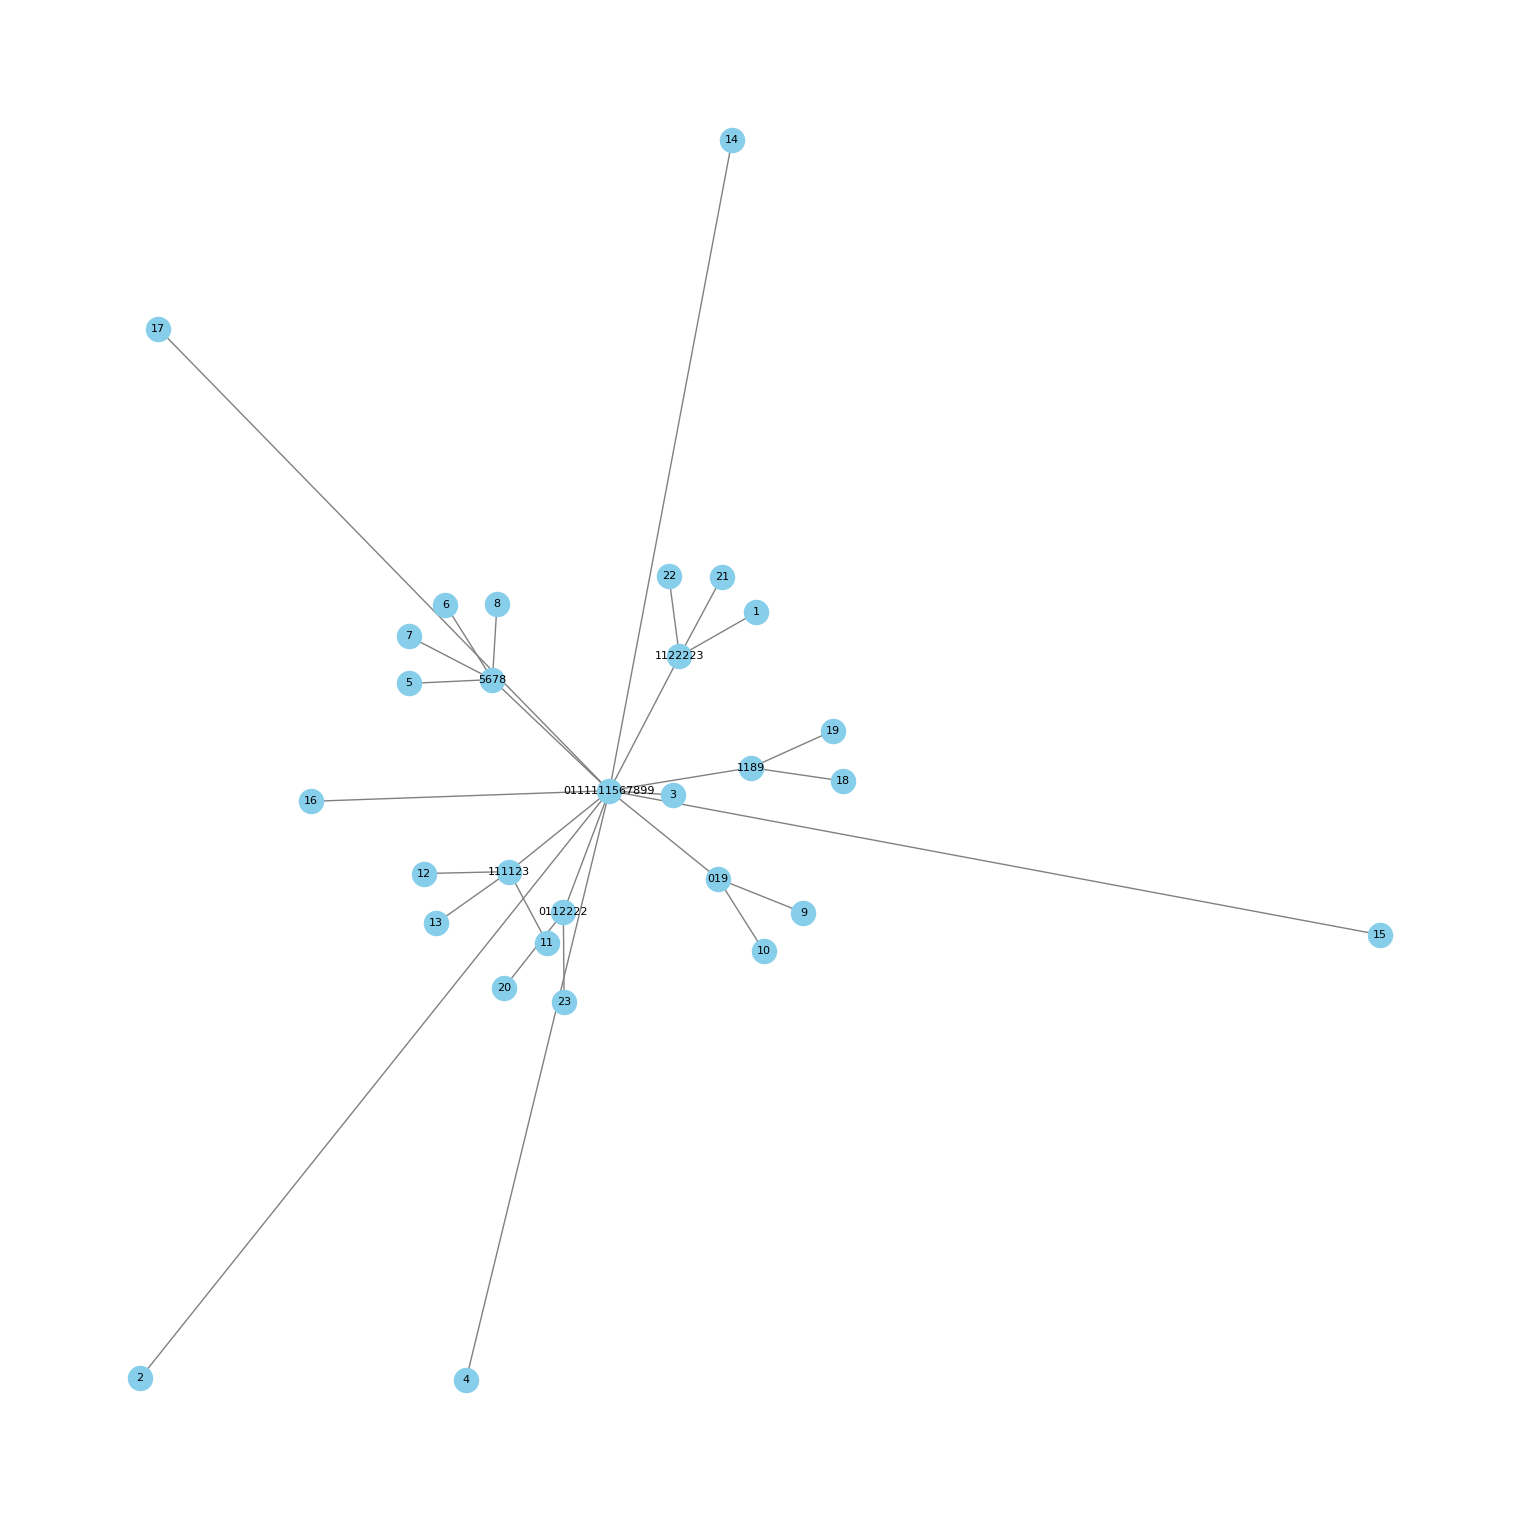

In [75]:
# Draw the graph
pos = nx.spring_layout(G)  # Layout algorithm (you can choose another one)

# Increase the figure size (adjust the width and height as needed)
plt.figure(figsize=(15, 15))

# Customize node and edge visual properties for clarity
nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=8, font_color='black', edge_color='gray', width=1.0)

# Display the graph
plt.axis('off')
plt.show()

# **write mst in newick**

In [57]:
import networkx as nx
from ete3 import Tree

def networkx_to_ete3(G, root_node):
    # Check if the root node exists in the graph
    if root_node not in G:
        raise ValueError(f"Root node '{root_node}' not found in the graph.")

    def add_children(node, ete3_node):
        for child in G.neighbors(node):
            # Add additional check to prevent backtracking to the parent
            if ete3_node.up is None or ete3_node.up.name != child:
                if not ete3_node.search_nodes(name=child):
                    child_node = ete3_node.add_child(name=child)
                    add_children(child, child_node)

    root = Tree(name=root_node)
    add_children(root_node, root)
    return root



# Example: Selecting a root node
#root_node = '11125'  # Replace 'some_node' with the name of your chosen root node
root_node = '0111111567899'  # Replace 'some_node' with the name of your chosen root node
ete3_tree = networkx_to_ete3(G, root_node)

# Save the tree to a file in Newick format
newick_path = "mst.txt"  # Replace with your desired file path
ete3_tree.write(format=1, outfile=newick_path)

print(f"Tree saved in Newick format to {newick_path}")


Tree saved in Newick format to mst.txt


**write mst in newick** Without Internal nodes

In [76]:
import networkx as nx
from ete3 import Tree

def networkx_to_ete3(G, root_node):
    if root_node not in G:
        raise ValueError(f"Root node '{root_node}' not found in the graph.")

    visited = set()  # To keep track of visited nodes

    def add_children(node, ete3_node, is_root=True):
        visited.add(node)  # Mark the current node as visited
        for child in G.neighbors(node):
            if child not in visited:
                # Set name only for leaf nodes
                child_node_name = child if G.degree[child] == 1 else ''
                child_node = ete3_node.add_child(name=child_node_name)
                add_children(child, child_node, is_root=False)

    root = Tree(name=root_node)
    add_children(root_node, root)
    return root

# Example usage
root_node = '0111111567899'  # Replace with your chosen root node
ete3_tree = networkx_to_ete3(G, root_node)

# Save the tree to a file in Newick format without internal node names
newick_path = "mst3.txt"
ete3_tree.write(format=1, outfile=newick_path)

print(f"Tree saved in Newick format to {newick_path}")


Tree saved in Newick format to mst3.txt


**with merge branch length**

In [77]:
import networkx as nx
from ete3 import Tree

def networkx_to_ete3(G, root_node):
    if root_node not in G:
        raise ValueError(f"Root node '{root_node}' not found in the graph.")

    visited = set()  # To keep track of visited nodes

    def add_children(node, ete3_node, is_root=True):
        visited.add(node)  # Mark the current node as visited
        for child in G.neighbors(node):
            if child not in visited:
                child_node_name = child if G.degree[child] == 1 else ''
                child_node = ete3_node.add_child(name=child_node_name)
                # Set the branch length (edge weight) for non-root nodes
                if not is_root:
                    branch_length = G[node][child].get('weight', 1.0)  # Default to 1.0 if no weight is found
                    child_node.dist = branch_length
                add_children(child, child_node, is_root=False)

    root = Tree(name=root_node)
    add_children(root_node, root)
    return root

# Example usage
root_node = '0111111567899'  # Replace with your chosen root node
ete3_tree = networkx_to_ete3(G, root_node)

# Save the tree to a file in Newick format with branch lengths
newick_path = "mst4.txt"
ete3_tree.write(format=1, outfile=newick_path)

print(f"Tree saved in Newick format to {newick_path}")


Tree saved in Newick format to mst4.txt


# **Rename_leaves**

In [ ]:
pip install Bio

In [ ]:
from Bio import Phylo
import re,io

# Your renaming dictionary
renaming_dict = {
    1: "Guangxi_Pangolin_P2V",
    2: "Guangdong_Pangolin_P2S_2019",
    3: "Guangdong_Pangolin_1_2019",
    4: "RaTG13",
    5: "Hu_Australia_VIC231_2020",
    6: "Hu_Wuhan_2020",
    7: "Hu_USA_UT_00346_2020",
    8: "Hu_Italy_TE4836_2020",
    9: "Bat_CoVZXC21",
    10: "Bat_CoVZC45",
    11: "BM48_31_BGR_2008",
    12: "BtKY72",
    13: "SARS",
    14: "Tor2",
    15: "SARS-CoV_BJ182-4",
    16: "Rs3367",
    17: "Bovine_CoV",
    18: "Bovine_OH440",
    19: "Human_ent_4408",
    20: "Bovine_AH187",
    21: "Rabbit_HKU14",
    22: "Porcine_v",
    23: "Equine_NC99",
    24: "Human_OC43",
    25: "HKU1",
    26: "Murine_A59",
    27: "Murine_RA59/R13",
    28: "Murine_virus",
    29: "Murine_JHM",
    30: "Rat_Parker",
    31: "Feline_per",
    32: "Bat_HKU5-1",
    33: "MERS-CoV_S",
    34: "Bat_HKU4-1",
    35: "BtCoV_273_2005",
    36: "Rf1",
    37: "BtCoV_279_2005",
    38: "HKU3-12",
    39: "HKU3-6",
    40: "Guangxi_Pangolin_P1E",
    41: "Guangxi_Pangolin_P4L",
    42: "Guangxi_Pangolin_P5L",
    43: "Guangxi_Pangolin_P5E"
}


**43Leaves**

In [ ]:
from Bio import Phylo
import re,io

renaming_dict = {
    "Guangxi_Pangolin_P2V": "1",
    "Guangdong_Pangolin_P2S_2019": "2",
    "Guangdong_Pangolin_1_2019": "3",
    "RaTG13": "4",
    "Hu_Australia_VIC231_2020": "5",
    "Hu_Wuhan_2020": "6",
    "Hu_USA_UT_00346_2020": "7",
    "Hu_Italy_TE4836_2020": "8",
    "Bat_CoVZXC21": "9",
    "Bat_CoVZC45": "10",
    "BM48_31_BGR_2008": "11",
    "BtKY72": "12",
    "SARS": "13",
    "Tor2": "14",
    "SARS-CoV_BJ182-4": "15",
    "Rs3367": "16",
    "Bovine_CoV": "17",
    "Bovine_OH440": "18",
    "Human_ent_4408": "19",
    "Bovine_AH187": "20",
    "Rabbit_HKU14": "21",
    "Porcine_v": "22",
    "Equine_NC99": "23",
    "Human_OC43": "24",
    "HKU1": "25",
    "Murine_A59": "26",
    "Murine_RA59/R13": "27",
    "Murine_virus": "28",
    "Murine_JHM": "29",
    "Rat_Parker": "30",
    "Feline_per": "31",
    "Bat_HKU5-1": "32",
    "MERS-CoV_S": "33",
    "Bat_HKU4-1": "34",
    "BtCoV_273_2005": "35",
    "Rf1": "36",
    "BtCoV_279_2005": "37",
    "HKU3-12": "38",
    "HKU3-6": "39",
    "Guangxi_Pangolin_P1E": "40",
    "Guangxi_Pangolin_P4L": "41",
    "Guangxi_Pangolin_P5L": "42",
    "Guangxi_Pangolin_P5E": "43"
}

# Function to rename leaves in a single tree
def rename_leaves(tree, renaming_dict):
    for leaf in tree.get_terminals():
        if leaf.name in renaming_dict:
            leaf.name = renaming_dict[leaf.name]

# Read the file containing the trees
with open('pruned_trees11.txt', 'r') as file:
    tree_data = file.read().splitlines()

# Process each tree
renamed_trees = []
for tree_str in tree_data:
    tree = Phylo.read(io.StringIO(tree_str), 'newick')
    rename_leaves(tree, renaming_dict)
    # Save the renamed tree to a list
    renamed_tree_str = io.StringIO()
    Phylo.write(tree, renamed_tree_str, 'newick')
    renamed_trees.append(renamed_tree_str.getvalue().strip())

# Write the renamed trees to a new file
with open('renamed_pruned_trees11.txt', 'w') as file:
    for tree_str in renamed_trees:
        file.write(tree_str + '\n')

**23Leaves**

In [ ]:
renaming_dict = {
    "Guangxi_Pangolin_P2V": "1",
    "Guangdong_Pangolin_P2S_2019": "2",
    "Guangdong_Pangolin_1_2019": "3",
    "RaTG13": "4",
    "Hu_Australia_VIC231_2020": "5",
    "Hu_Wuhan_2020": "6",
    "Hu_USA_UT_00346_2020": "7",
    "Hu_Italy_TE4836_2020": "8",
    "Bat_CoVZXC21": "9",
    "Bat_CoVZC45": "10",
    "SARS": "11",
    "Tor2": "12",
    "SARS-CoV_BJ182-4": "13",
    "Rs3367": "14",
    "BtCoV_273_2005": "15",
    "Rf1": "16",
    "BtCoV_279_2005": "17",
    "HKU3-12": "18",
    "HKU3-6": "19",
    "Guangxi_Pangolin_P1E": "20",
    "Guangxi_Pangolin_P4L": "21",
    "Guangxi_Pangolin_P5L": "22",
    "Guangxi_Pangolin_P5E": "23"
}


# Function to rename leaves in a single tree
def rename_leaves(tree, renaming_dict):
    for leaf in tree.get_terminals():
        if leaf.name in renaming_dict:
            leaf.name = renaming_dict[leaf.name]

# Read the file containing the trees
with open('pruned_trees12.txt', 'r') as file:
    tree_data = file.read().splitlines()

# Process each tree
renamed_trees = []
for tree_str in tree_data:
    tree = Phylo.read(io.StringIO(tree_str), 'newick')
    rename_leaves(tree, renaming_dict)
    # Save the renamed tree to a list
    renamed_tree_str = io.StringIO()
    Phylo.write(tree, renamed_tree_str, 'newick')
    renamed_trees.append(renamed_tree_str.getvalue().strip())

# Write the renamed trees to a new file
with open('renamed_pruned_trees12.txt', 'w') as file:
    for tree_str in renamed_trees:
        file.write(tree_str + '\n')

# **Count#leaves**

In [ ]:
from Bio import Phylo
import io

def count_leaves_in_tree(tree_str):
    tree = Phylo.read(io.StringIO(tree_str), "newick")
    return len(tree.get_terminals())

# Path to your file containing 11 trees in Newick format
file_path = 'renamed_pruned_trees12.txt'
# file_path = '/content/12_Covid-19_gene trees_original_23-46_taxa.nwk'
# Read the file and split it into individual trees (assuming one tree per line)
with open(file_path, 'r') as file:
    tree_strings = file.read().splitlines()

# Count leaves in each tree
leaf_counts = [count_leaves_in_tree(tree_str) for tree_str in tree_strings]

# Print leaf count for each tree
for i, count in enumerate(leaf_counts, 1):
    print(f"Number of leaves in tree {i}: {count}")


Number of leaves in tree 1: 23
Number of leaves in tree 2: 23
Number of leaves in tree 3: 23
Number of leaves in tree 4: 23
Number of leaves in tree 5: 23
Number of leaves in tree 6: 23
Number of leaves in tree 7: 23
Number of leaves in tree 8: 23
Number of leaves in tree 9: 23
Number of leaves in tree 10: 23
Number of leaves in tree 11: 23
Number of leaves in tree 12: 23
Number of leaves in tree 13: 23


# **Keep_Common_leaves**

In [ ]:
from Bio import Phylo
import io

def get_common_leaves(tree_strings):
    leaf_sets = []
    for tree_str in tree_strings:
        tree = Phylo.read(io.StringIO(tree_str), "newick")
        leaves = set(leaf.name for leaf in tree.get_terminals())
        leaf_sets.append(leaves)
    return set.intersection(*leaf_sets)

def prune_tree(tree, common_leaves):
    for leaf in tree.get_terminals():
        if leaf.name not in common_leaves:
            tree.prune(leaf)
    return tree

# Path to your file containing 12 trees in Newick format
file_path = '/content/trees12_with_sp.txt'

# Read the file and split it into individual trees (assuming one tree per line)
with open(file_path, 'r') as file:
    tree_strings = file.read().splitlines()

# Find common leaves
common_leaves = get_common_leaves(tree_strings)

# Prune each tree
pruned_trees = []
for tree_str in tree_strings:
    tree = Phylo.read(io.StringIO(tree_str), "newick")
    pruned_tree = prune_tree(tree, common_leaves)
    pruned_tree_str = io.StringIO()
    Phylo.write(pruned_tree, pruned_tree_str, 'newick')
    pruned_trees.append(pruned_tree_str.getvalue().strip())

# Write the pruned trees to a new file
with open('pruned_trees12_with_sp.txt', 'w') as file:
    for tree_str in pruned_trees:
        file.write(tree_str + '\n')
